In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import time

import warnings
warnings.filterwarnings('ignore')

# 데이터 준비 
사용할 데이터의 길이 (seq_length) 설정

In [2]:
df = pd.read_csv('./data/BTC-M.csv',parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head(3)

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359


In [3]:
from pymodule.dllMod import pred_per
pred = pred_per(df, 0.04)

In [4]:
from pymodule.dataMod import OHLCDataset

seq_length = 70
dataset = OHLCDataset(df[10:-4], pred[10:-4], seq_length)

In [5]:
from torch.utils.data import DataLoader, random_split

test_size = 262144
train_set, test_set = random_split(dataset, [len(dataset) - test_size, test_size])
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')

train_dloader = DataLoader(train_set, batch_size=512, shuffle=True, drop_last=True)
test_dloader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True)

train dataset length : 1523574
test dataset length : 262144


# 모델, 옵티마이저, 로스함수 설정

In [7]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [8]:
from pymodule.models import OLNN
import torch.optim as optim
import torch.nn as nn

model = OLNN(seq_length).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

# 모델 학습

In [9]:
path = "./OLNN.pt"
losses = []
val_losses = []
model = torch.load(path).to(device)

In [11]:
from pymodule.models import fit

start = time.time()
for epoch in range(30):
    epoch_loss = fit(epoch,model,train_dloader, criterion, optimizer, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dloader, criterion, optimizer, phase ='valid')
    val_losses.append(val_epoch_loss)
    print("{:0,.2f}분".format((time.time()-start)/60))
# torch.save(model, path)

epoch:0, trainloss is 0.00017677543812760483
epoch:0, validloss is 0.0001184570203633939
1.33분
epoch:1, trainloss is 0.00017739658438423961
epoch:1, validloss is 0.00011845794153764189
2.70분
epoch:2, trainloss is 0.00017620109739085253
epoch:2, validloss is 0.00011845827907563944
4.05분
epoch:3, trainloss is 0.00017688772095467785
epoch:3, validloss is 0.00011845808151811354
5.37분
epoch:4, trainloss is 0.00017672824376107526
epoch:4, validloss is 0.00011845855130054872
6.68분
epoch:5, trainloss is 0.00017667428129628394
epoch:5, validloss is 0.00011845793324027909
8.04분
epoch:6, trainloss is 0.00017728734072437646
epoch:6, validloss is 0.00011845782898589619
9.41분
epoch:7, trainloss is 0.00017684088521703096
epoch:7, validloss is 0.00011845732527504538
10.74분
epoch:8, trainloss is 0.00017739473764568636
epoch:8, validloss is 0.00011845850729930163
12.09분
epoch:9, trainloss is 0.00017671577947669026
epoch:9, validloss is 0.00011845820335842916
13.46분
epoch:10, trainloss is 0.0001767568238

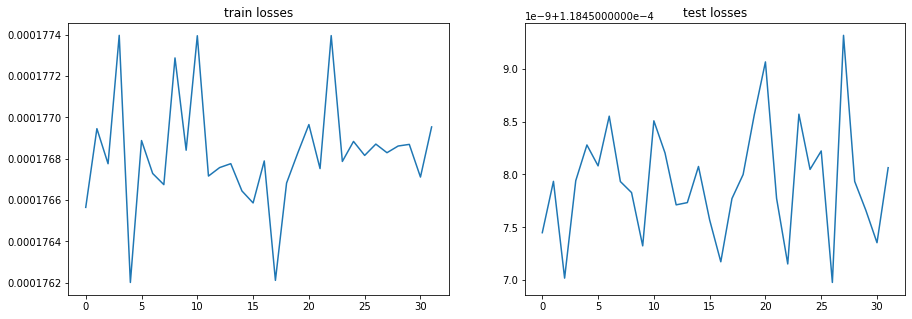

In [12]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('train losses')

ax[1].plot(val_losses)
ax[1].set_title('test losses')
plt.show()